# ***Urban Mobility for 5G Cellular Networks***

The scenario considered is a urban 5G scenario in the center of the city of Cologne (900 x 700 meters), with 5G
enabled vehicles that move around while being continuously connected to the 5G network. The mobility
is emulated with SUMO, an open-source traffic simulation suite that allows generating the movement of
emulated users around a predefined city road map, and extracting the needed metrics. Base stations
(BSs) were deployed on a grid topology, and the mobility area has been covered with hexagonal 5G cells
with a radius of 40 m, each with a BS in its center.

The dataset is composed of two files.
1. In the file "traces.mat" the following mesurements are provided: 
    * time of the measurement in seconds;
    * vehicle ID;
    * absolute x coordinate of the vehicle location in meters;
    * absolute y coordinate of the vehicle location in meters;
    * speed of the vehicle in meters over second;
    * hexagonal cell associated with the x-y location (i.e., serving base station (BS));
    * hexagonal cell to which the user will be connected in the next time step (cell C+1);
    * hexagonal cell visited before the current one (cell C-1) no matter how much time before (i.e., previous serving BS);
    * hexagonal cell C-2;
    * hexagonal cell C-3;

A negative number in a cell column is referred to time steps out of the recorded trajectory.

2. The file "coordinate_BS.mat" provides:
    * absolute x coordinate of the BS location in meters;
    * absolute y coordinate of the BS location in meters;



## Import Libs

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, TextBox
import scipy.io as sio
import csv
import pickle
import os

from matplotlib.patches import RegularPolygon
from matplotlib.animation import FuncAnimation
# Lib with some useful functions
import VF as vf

In [2]:
bs_coordinates, traces = vf.get_data()
print("Provided data: ")
traces.head()

Provided data: 


,time,id,x,y,speed,C,C+1,C-1,C-2,C-3
0,37081.0,1.0,13379.670000,13854.720000,0.00,174.0,174.0,-5.0,-6.0,-7.0
1,37082.0,1.0,13379.322115,13852.335241,2.41,174.0,174.0,-5.0,-6.0,-7.0
2,37083.0,1.0,13378.633564,13847.615199,4.77,174.0,174.0,-5.0,-6.0,-7.0
3,37084.0,1.0,13377.623111,13840.688512,7.00,174.0,174.0,-5.0,-6.0,-7.0
4,37085.0,1.0,13376.544813,13833.296749,7.47,174.0,174.0,-5.0,-6.0,-7.0


## *Proposed challanges*

Location information and prediction can be exploited to enhance the 5G network performance, through location and mobility-aware allocation of communications and computing tasks in 5G edge networks.

The proposed challenges exploit vehicles mobility to estimate and predict useful information for network management.

The problems considered in the notebook are:
   * dynamic visualization of the provided data;
   * prediction and visualization of the time a user will remain under the coverage of a BS;
   * estimation of the position where the vehicle can be found in subsequent time instants with linear regression and Kalman filter;
   * estimation of the next serving BS and prediction of the number of users inside each cell for the following time slots.

## Functions for data visualizations

In [3]:
def update_bs_cells(traces, curtime, figurename, bs_position, cmap_scale_color):
    [old_patches.remove() for old_patches in reversed(figurename.patches)]
    cars_per_bs = vf.BS_get_Ncar_by_time(traces, curtime)
    for xbs, ybs, ncarbs in zip(bs_position['x'], bs_position['y'], cars_per_bs):
        color = cmap_scale_color(ncarbs / auto_per_BS)
        hex_patch_apply = RegularPolygon((xbs, ybs), numVertices=6, radius=40,
                                         orientation=np.radians(30),
                                         facecolor=color, edgecolor='k')
        figurename.add_patch(hex_patch_apply)
    fig.canvas.draw_idle()


def update_car_pos(traces, curtime, cur_car_ax, colormap_dict):
    cur_car_ax.clear()
    cur_car_ax.set_xlabel("X coordinate [m]")
    cur_car_ax.set_title("Current car position")
    cur_car_ax.set_xlim(0, 900)
    cur_car_ax.set_ylim(0, 1050)
    cur_car_ax.set_aspect('equal')
    cur_car_ax.imshow(plt.imread('background.png'), origin='lower')
    vehicle_coordinates = vf.get_car_pos_by_time(traces, curtime)
    car_color = np.zeros((vehicle_coordinates[:, 0].size, 3))
    i = 0
    for ids in vehicle_coordinates[:, 0]:
        car_color[i, :] = colormap_dict[ids]
        i += 1
    cur_car_ax.scatter(vehicle_coordinates[:, 1], vehicle_coordinates[:, 2], s=50, marker='.', c=car_color)


# spit traces in hours.
def cut_trace_into_smaller_time(input_traces):
    # time-step -> from 3845 to 86308 -> about 22.9 hours , 82463 sec
    input_traces['x'] = input_traces['x'] - 12700  # Normalize points 12700<x<13600 = 900px
    input_traces['y'] = input_traces['y'] - 13200  # Normalize points 13200<y<14250 = 1050px
    for i in range(0, 23):
        cur_trace = input_traces[
            (3845 + 3600 * i <= input_traces['time']) & (input_traces['time'] < 3845 + 3600 * (+i + 1))]
        cur_trace.to_pickle('data_fast_loading/traces_hour_' + str(i) + '.plk')


# get correct trace
def get_fast_trace(desired_trace_time):
    # time-step -> from 3845 to 86308 -> about 22.9 hours , 82463 sec
    hour = math.floor((desired_trace_time - 3845) / 3600.0)
    return pd.read_pickle('data_fast_loading/traces_hour_' + str(hour) + '.plk')

## Data Visualization

<IPython.core.display.Javascript object>


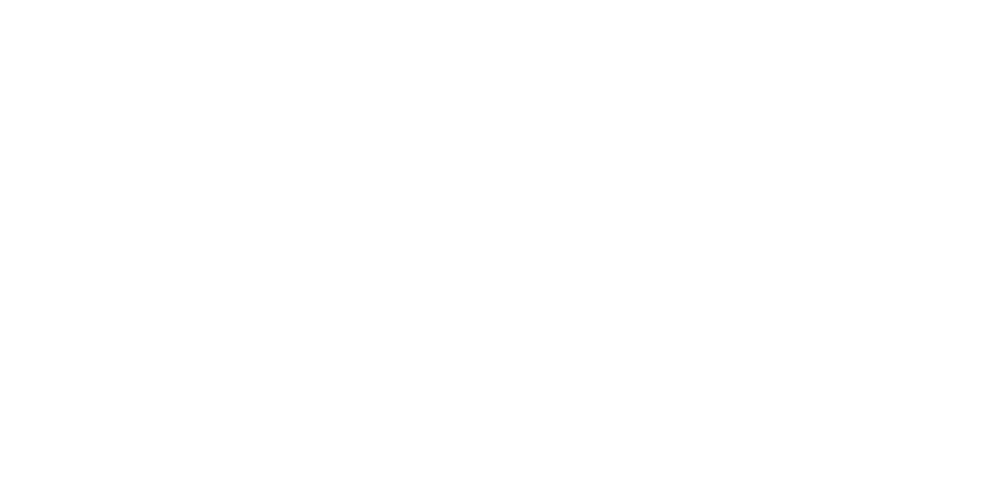

In [4]:
    %matplotlib nbagg
    
    bs_coordinates, traces = vf.get_data()
    
    if not os.path.exists('data_fast_loading'):
        os.makedirs('data_fast_loading')
    
    # fast loading sequence
    try:
        bs_coordinates = pd.read_pickle('data_fast_loading/fast_bs_coordinates.plk')
        times = np.load('data_fast_loading/fast_times.npy')
        with open('data_fast_loading/fast_carID_colorDict.plk', 'rb') as handle:
            color_dict = pickle.load(handle)
        ft_g = np.load('data_fast_loading/fast_ft_g.npy')
        nv_g = np.load('data_fast_loading/fast_nv_g.npy')
        pass
    except IOError:
        print("Could not read files, slow loading started.")
        bs_coordinates, traces = vf.get_data()
        cut_trace_into_smaller_time(traces)
        bs_coordinates['x'] = bs_coordinates['x'] - 12700  # Normalize points 12700<x<13600 = 900px
        bs_coordinates['y'] = bs_coordinates['y'] - 13200  # Normalize points 13200<y<14250 = 1050px
        bs_coordinates.to_pickle('data_fast_loading/fast_bs_coordinates.plk')
        # Get every time-step -> from 3845 to 86308 -> about 22.9 hours
        times = vf.compute_uniq_times(traces)
        np.save('data_fast_loading/fast_times', times)
        car_ID = vf.compute_uniq_id(traces)
        color_dict = vf.assign_colors(car_ID)
        with open('data_fast_loading/fast_carID_colorDict.plk', 'wb') as handle:
            pickle.dump(color_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        ft_g, nv_g = vf.vehicle_count(traces, times, step=100, save=False)
        np.save('data_fast_loading/fast_ft_g', ft_g)
        np.save('data_fast_loading/fast_nv_g', nv_g)

    traces = get_fast_trace(ft_g[0])
    prev_traces_time = ft_g[0]
    # set up the 3 plots
    fig, [ax_cell, ax_car, ax_way] = plt.subplots(1, 3, figsize = (10,5))
    ax_cell.set_title("BS load")
    ax_cell.set_ylabel("Y coordinate [m]")
    
    ax_car.set_title("Current car position")

    
    ax_way.set_title("BS map")
    
    
    plt.subplots_adjust(left=0.10, bottom=0.4)

    # -----------------------------------------------------------------------------SLIDER
    axTime = plt.axes([0.15, 0.15, 0.70, 0.06])
    sTime = Slider(axTime, 'Time[s]', ft_g[0], ft_g[-1], valstep=100)
    p, = plt.plot(ft_g, nv_g, linewidth=2, color='red')

    # -----------------------------------------------------------------------------TEXT BOX
    axbox = plt.axes([0.425, 0.05, 0.05, 0.075])
    text_box = TextBox(axbox, label='', initial=str(ft_g[0]))

    # ------------------------------------------------------------------------------NEXT BUTTON

    axnext = plt.axes([0.3, 0.05, 0.1, 0.075])
    bnext = Button(axnext, '+1 sec')

    # ------------------------------------------------------------------------------PREV BUTTON
    axprev = plt.axes([0.5, 0.05, 0.1, 0.075])
    bprev = Button(axprev, '-1 sec')

    # -------------------------------------------------------------------------------------------Plot Base-Stations cells
    colormap_scale = plt.get_cmap('viridis')  # settings colorscale
    auto_per_BS = 10  # max number of car per cell, if bigger->saturation
    # -----------------
    ax_cell.set_aspect('equal')
    ax_cell.set_xlim(0, 900)
    ax_cell.set_ylim(0, 1050)
    ax_cell.scatter(bs_coordinates['x'], bs_coordinates['y'], alpha=0)
    # plot base station for the first time
    update_bs_cells(traces, ft_g[0], ax_cell, bs_coordinates, colormap_scale)
    ax_cell.margins(x=0)

    # -------------------------------------------------------------------------------------------Plot Car by time
    update_car_pos(traces, ft_g[0], ax_car, color_dict)
    # ax_car.scatter(bs_coordinates['x'], bs_coordinates['y'], marker='s', s=5)  # Plot Base-Stations


    # -------------------------------------------------------------------------------------------Plot Street
    ax_way.set_aspect('equal')
    ax_way.set_xlim(0, 900)
    ax_way.set_ylim(0, 1050)
    ax_way.imshow(plt.imread('background.png'), origin='lower')
    ax_way.scatter(bs_coordinates['x'], bs_coordinates['y'], marker='s', s=5)  # Plot Base-Stations


    # -----------------------------------------------------------------------------RELOAD PLOTS
    def update(val):
        global traces
        text_box.set_val(int(val))
        if math.floor((prev_traces_time - 3845) / 3600.0) != math.floor((val - 3845) / 3600.0):
            traces = get_fast_trace(val)  # refresh traces
        update_bs_cells(traces, sTime.val, ax_cell, bs_coordinates, colormap_scale)
        update_car_pos(traces, sTime.val, ax_car, color_dict)
        # ax_car.scatter(bs_coordinates['x'], bs_coordinates['y'], marker='s', s=5)  # Plot Base-Stations


    def submitTime(text):
        new_val_sec = float(text)
        if new_val_sec > ft_g[-1]:
            new_val_sec = ft_g[-1]
        elif new_val_sec < ft_g[0]:
            new_val_sec = ft_g[0]
        sTime.set_val(int(new_val_sec))


    def next_time(event):
        new_val_sec = int(sTime.val) + 1
        if new_val_sec > ft_g[-1]:
            new_val_sec = ft_g[-1]
        elif new_val_sec < ft_g[0]:
            new_val_sec = ft_g[0]
        sTime.set_val(int(new_val_sec))


    def prev_time(event):
        new_val_sec = int(sTime.val) - 1
        if new_val_sec > ft_g[-1]:
            new_val_sec = ft_g[-1]
        elif new_val_sec < ft_g[0]:
            new_val_sec = ft_g[0]
        sTime.set_val(int(new_val_sec))


    text_box.on_submit(submitTime)
    sTime.on_changed(update)
    bnext.on_clicked(next_time)
    bprev.on_clicked(prev_time)

    mng = plt.get_current_fig_manager()
    #mng.window.state('zoomed')  # Open plot full screen on windows
    plt.show()
    

## Vehicle time under coverage of a BS analysis

### Data and libraries import

In [5]:
import csv

# Import Plotting lib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.patches import RegularPolygon
from scipy.stats import norm
import seaborn as sns; sns.set()
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches


# Import bokeh, an interactive visualization library that affords high-performance interactivity over large datasets
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

################################
# Import the .mat dataset and convert to pandas dataframe

# Import the .mat files
import_mat = sio.loadmat('coordinate_BS.mat')
import_traces = sio.loadmat('traces.mat')

# Convert extracted data into pandas Dataframe adding header
bs_coordinates = pd.DataFrame(import_mat['BSCoordinates'], columns=['x', 'y'])
vehicle_traces = pd.DataFrame(import_traces['traces_data'], columns=['time', 'id', 'x', 'y', 'speed', 'C', 'C+1', 'C-1', 'C-2', 'C-3'])

### Data extraction functions

In [6]:
######################################
#Creating a dict with the position of each bs as value - not useful for the analysis

bs_dict={}

for i, row in bs_coordinates.iterrows():

    bs_dict["BS-"+str(i+1)] = [row['x'], row['y']]

##################################### 
#Functions that crop the dataset between two time extremes
#maintain only the Id fully into the cropped part

def crop_df_by_time(a,t0,tf):
    
    a.sort_values(by=['time'], inplace=True)
    
    a=a.loc[(a['time']>=t0-1) & (a['time']<tf+1)]
    
    a.reset_index(inplace=True,drop=True)

    l=len(a)-1

    while(a.loc[len(a)-2, 'time'] == a.loc[len(a)-1, 'time']):
        a = a.drop(a.index[l])
        l=l-1
        
    removed_t0_minus=False
    removed_tf_plus=False
    
    l=len(a)-1
    
    if (a.loc[0, 'id'] == a.loc[1, 'id']):
        a = a[a['id'] != a.loc[0,'id']]
        removed_t0_minus=True
        
    if (a.loc[l-1, 'id'] == a.loc[l, 'id']):
        a = a[a['id'] != a.loc[l,'id']]
        removed_tf_plus=True
        
    if (not removed_t0_minus):
        a = a.drop(a.index[0])
    
    if (not removed_tf_plus):
        a = a.drop(a.index[l])
        
    return a
    
############################
#Functions that return the df with only the activity registered by a base station
    
def bs_activity(x):
    
    mask = vehicle_traces['C'].isin([x])
    bs_activity_df = vehicle_traces[mask]
    
    #avoid warning creating a copy 'a' of the df
    a=bs_activity_df.drop(['C+1', 'C-1', 'C-2', 'C-3'],axis=1)
    
    return a

###########################
#Functon that returns the vector of unique id and the vector of their respective times under coverage of a bs from t0 to tf
#The parameter wnd permit to select the percentage of the dataset to analyze, in case we want to prepare the data 
#for a ml algorithm wich require nly a part of the df for training

def time_under_bs_prediction(x,t0,tf,wnd):
    
    a = bs_activity(x)

    full_df = crop_df_by_time(a,t0,tf)
        
    t_wnd_tf=t0+int((tf-t0)*wnd)
    
    wnd_df = crop_df_by_time(a,t0,t_wnd_tf)
    
    uniq_id = np.unique(wnd_df['id'])
    
    id_time = np.zeros([len(uniq_id)])
    
    for i in range(len(uniq_id)):
        id_time[i] = (wnd_df['id'] == uniq_id[i]).sum()
    
    return uniq_id, id_time

############################
#Simpler version of the previous function that return only the full vector (wnd=1) 
#of times under coverage between an intervall

def id_times(a,t0,tf):
    
    full_df = crop_df_by_time(a, t0, tf)
    uniq_id = np.unique(full_df['id'])
    id_time = np.zeros([len(uniq_id)])
    
    for i in range(len(uniq_id)):
        id_time[i] = (full_df['id'] == uniq_id[i]).sum()
        
    return id_time
   
##################################
#Function that returns the daily times under coverage of a bs divided in five day time divisions
   
def full_day_bs_coverage(x):
    
    a = bs_activity(x)    
    a.sort_values(by=['time'], inplace=True)
    a.reset_index(inplace=True,drop=True)
    
    tot_l=len(a)-1
    
    first_time = a.loc[0,'time']
    last_time =  a.loc[tot_l,'time']
    
    p1=id_times(a,first_time,20000) #first part of night from the first time registered to 20000 seconds (20000/3600 = 5.5)
    p2=id_times(a,20000,40000) # early morning
    p3=id_times(a,40000,50000) #late morning and early afternoon
    p4=id_times(a,50000,70000) # late afternoon until night
    p5=id_times(a,70000,last_time) #second part of the night until the end of the recording
    
    return p1, p2, p3, p4, p5

### Kernel density estimation histogram function

In [7]:
def wnd_percentage_difference(bs):

    #Comparing the activity on a sigle time interval (45000 - 65000 seconds) with different wnd percentages 20% 50% 80%

    id_out1, times_out1 = time_under_bs_prediction(bs,45000,65000,0.2)
    id_out2, times_out2 = time_under_bs_prediction(bs,45000,65000,0.5)
    id_out3, times_out3 = time_under_bs_prediction(bs,45000,65000,0.8)

    fig, ax = plt.subplots(figsize=(10,10))
    
    plt.xlabel('Time under coverage [s]')
    plt.ylabel('Normalized frequency')

    plt.title('Activity under the Bs-' + str(bs) + ' from time 45000 to 65000 [s]')


    sns.distplot(times_out1, bins=int(max(times_out1)), norm_hist=True, color="b", ax=ax)

    sns.distplot(times_out2, bins=int(max(times_out2)), norm_hist=True, color="g", ax=ax)

    sns.distplot(times_out3, bins=int(max(times_out3)), norm_hist=True, color="r", ax=ax)

    blue_patch = mpatches.Patch(color='b', label='20 % window size')
    green_patch = mpatches.Patch(color='g', label='50 % window size')
    red_patch = mpatches.Patch(color='r', label='80 % window size')

    plt.legend(handles=[blue_patch, green_patch, red_patch])

    plt.show()

### Dynamic histogram plots functions

In [8]:
def time_under_coverage_analysis_bs(bs):

    #Extracting the data recorded during the day and creating 5 df of times under coverage 
    #in the different parts of the day

    p1, p2, p3, p4, p5 = full_day_bs_coverage(bs)

    #Concatenating the 5 parts of day dataframes in a sinle df
    b = np.concatenate((p1, p2, p3, p4, p5), axis=None)

    #Adding a column with the name of the respective part of the day
    day_parts = []

    for x in range(len(p1)):
        day_parts.append('Night (24-5)')
    for x in range(len(p2)):
        day_parts.append('Early Morning (5-11)')
    for x in range(len(p3)):
        day_parts.append('Late Morning/Early Afternoon (11-14)')
    for x in range(len(p4)):
        day_parts.append('Late Afternoon (14-20)')
    for x in range(len(p5)):
        day_parts.append('Night (20-24)')


    full_time_coverage = pd.DataFrame({'seconds': b, 
                           'part_of_day': day_parts })

    #simple list of the five string corrisponding to different day time division
    time_division = list(full_time_coverage['part_of_day'].unique())

    #five normal distributrions division - not useful for the analysis
    gaussian_division = ['dist1', 'dist2', 'dist3', 'dist4', 'dist5']

    ##########################################################################################################################

    #Dynamic histogram plot

    #Repeting import of libraries for avoiding a bokeh error

    from bokeh.io import show, output_notebook, push_notebook
    from bokeh.plotting import figure

    from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
    from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

    from bokeh.layouts import column, row, WidgetBox
    from bokeh.palettes import Category20_16

    from bokeh.application.handlers import FunctionHandler
    from bokeh.application import Application

    output_notebook()  #this function will show the plot in the notebook instead of opening an external html page 

    #A way to make interactive plots is to embed a bokeh application into jupyter.

    #The modify function embed all the function necessary to generate the dataframe, plot and eventually update the data 
    #relying on what types of data is interactively selected

    def modify_doc(doc):

        ########################################
        #The makedatest functions prepare the selected data to be plotted

        def make_dataset(time_division_list, bins_number, range_start, range_end):

            by_part = pd.DataFrame(columns=['proportion', 'left', 'right', 'number_id_for_bin', 'name', 'color'])

            # Iterate through all the carriers
            for i, part_of_day in enumerate(time_division_list):

                # Subset to the carrier
                subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

                # Create a histogram with specified bins and range
                arr_hist, edges = np.histogram(subset['seconds'], 
                                               bins = int(bins_number), 
                                               range = [range_start, range_end],
                                               density = True)

                # Create a not normalized histogram. This will give us the number of cars in every bin
                arr_hist2, edges2 = np.histogram(subset['seconds'], 
                                                 bins = int(bins_number), 
                                                 range = [range_start, range_end])


                # Divide the counts by the total to get a proportion and create df
                arr_df = pd.DataFrame({'proportion': arr_hist/np.sum(arr_hist), 
                                       'left': edges[:-1], 'right': edges[1:] })

                # Assign number of vehicle fr every bin
                arr_df['number_id_for_bin'] = arr_hist2

                # Assign the carrier for labels
                arr_df['name'] = part_of_day

                # Color each carrier differently
                arr_df['color'] = Category20_16[i*2]

                # Add to the overall dataframe
                by_part = by_part.append(arr_df)

            # Sorting overall dataframe - not usefull already sorted
            #by_part = by_part.sort_values(['name', 'left'])

            return ColumnDataSource(by_part)  # The column data source function transform a dataframe or a dictionary in 
                                              # an object that can be used as source of data by the bokeh plotting functions

        ############################################
        #The style function simply set the style of the text in labels and title

        def style(p):
            # Title 
            p.title.align = 'center'
            p.title.text_font_size = '20pt'
            p.title.text_font = 'serif'

            # Axis titles
            p.xaxis.axis_label_text_font_size = '14pt'
            p.xaxis.axis_label_text_font_style = 'bold'
            p.yaxis.axis_label_text_font_size = '14pt'
            p.yaxis.axis_label_text_font_style = 'bold'

            # Tick labels
            p.xaxis.major_label_text_font_size = '12pt'
            p.yaxis.major_label_text_font_size = '12pt'

            return p

        ######################################### 
        #The make plot function plt the histogram and generate the hoovers (info that compare when an object is highlighted)

        def make_plot(src1):
            # Blank plot with correct labels
            p = figure(plot_width = 700, plot_height = 700, 
                      title = 'Daily activity time under the Bs-' + str(bs),
                      x_axis_label = 'Time under coverage [s]', y_axis_label = 'Frequency')

            # Quad glyphs to create a histogram
            p.quad(source = src1, bottom = 0, top = 'proportion', left = 'left', right = 'right',
                   color = 'color', name = 'histo', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
                   hover_fill_alpha = 1.0, line_color = 'black')

            # Hover tool with vline mode
            hover1 = HoverTool(names=['histo'], tooltips=[('Sojourn time', '@left seconds'),
                              ('Number of vehicles', '@number_id_for_bin')],
                              mode='vline')

            p.add_tools(hover1)

            p.legend.click_policy = 'hide'

            #Adding hovers
            #p.add_tools(hover1)
            #p.add_tools(hover2)

            # Styling
            p = style(p)
            return p

        ###################################
        #The update function use the interactive input of the bokeh 'CheckboxGroup' object and 
        #update the 'making' of the dataset that will be plotted

        def update(attr, old, new):

            # Get the list of carriers for the graph
            period_to_plot = [period_selection.labels[i] for i in 
                                period_selection.active]

            # Make a new dataset based on the selected carriers and the 
            # make_dataset function defined earlier
            new_src = make_dataset(period_to_plot, int(max(b)), 0, int(max(b)))

            # Update the source used in the quad glpyhs
            src.data.update(new_src.data)

            #src = new_src
            #src2 = new_src2

        ############################

        period_selection = CheckboxGroup(labels=time_division, active = [0, 1, 2, 3, 4]) #The object that permits the user to
        period_selection.on_change('active', update)                                     #select interactively the data

        controls = WidgetBox(period_selection)

        initial_time = [period_selection.labels[i] for i in period_selection.active]

        src = make_dataset(initial_time, int(max(b)), 0, int(max(b)))

        p = make_plot(src)

        layout = row(controls, p)
        doc.add_root(layout)



    # Set up an application
    handler = FunctionHandler(modify_doc)
    app = Application(handler)

    show(app)

    #######################################################################################################################

    #Static interactive bokeh plot with the addition of the normal distribution for each part of the day

    def make_dataset_static_plot(time_division_list, bins_number, range_start, range_end):

        by_part = pd.DataFrame(columns=['proportion', 'left', 'right', 'number_id_for_bin', 'name', 'color'])

        # Iterate through all the carriers
        for i, part_of_day in enumerate(time_division_list):

            # Subset to the carrier
            subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

            # Create a histogram with specified bins and range
            arr_hist, edges = np.histogram(subset['seconds'], 
                                           bins = int(bins_number), 
                                           range = [range_start, range_end],
                                           density = True)

            arr_hist2, edges2 = np.histogram(subset['seconds'], 
                                             bins = int(bins_number), 
                                             range = [range_start, range_end])


            # Divide the counts by the total to get a proportion and create df
            arr_df = pd.DataFrame({'proportion': arr_hist/np.sum(arr_hist), 
                                   'left': edges[:-1], 'right': edges[1:] })

            # Assign number of vehicle fr every bin
            arr_df['number_id_for_bin'] = arr_hist2

            # Assign the carrier for labels
            arr_df['name'] = part_of_day

            # Color each carrier differently
            arr_df['color'] = Category20_16[i*2]

            # Add to the overall dataframe
            by_part = by_part.append(arr_df)

        # Overall dataframe
        #by_part = by_part.sort_values(['name', 'left'])

        return by_part

    ########

    def make_dataset2_static_plot(time_division_list, range_num):

        #by_part2 = pd.DataFrame(columns=['x', 'pdf', 'sigma', 'mu', 'color'])

        by_part2 = []

        # Iterate through all the carriers
        for i, part_of_day in enumerate(time_division_list):

            # Subset to the carrier
            subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

            b = np.asarray(subset['seconds'])

            x = np.linspace(0, int(range_num), 1000)
            sigma = np.std(b)
            mu = np.mean(b)

            sigma1 = np.full(1000, sigma)
            mu1 = np.full(1000, mu)

            pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))

            normal_dist = pd.DataFrame({'x': x, 'pdf':pdf, 'sigma': sigma1, 'mu': mu1 })

            normal_dist['color'] = Category20_16[i*2]

            # Add to the overall dataframe
            by_part2.append(normal_dist)    

        return by_part2

    #######


    def style_static_plot(p):
            # Title 
            p.title.align = 'center'
            p.title.text_font_size = '20pt'
            p.title.text_font = 'serif'

            # Axis titles
            p.xaxis.axis_label_text_font_size = '14pt'
            p.xaxis.axis_label_text_font_style = 'bold'
            p.yaxis.axis_label_text_font_size = '14pt'
            p.yaxis.axis_label_text_font_style = 'bold'

            # Tick labels
            p.xaxis.major_label_text_font_size = '12pt'
            p.yaxis.major_label_text_font_size = '12pt'

            return p

    def make_plot_all_static(src1, src2):
            # Blank plot with correct labels
            p = figure(plot_width = 700, plot_height = 700, 
                      title = 'Daily activity time under the Bs-' + str(bs),
                      x_axis_label = 'Time under coverage [s]', y_axis_label = 'Frequency')

            # Quad glyphs to create a histogram
            p.quad(source = src1, bottom = 0, top = 'proportion', left = 'left', right = 'right',
                   color = 'color', name = 'histo', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
                   hover_fill_alpha = 1.0, line_color = 'black')

            # Hover tool with vline mode
            hover1 = HoverTool(names=['histo'], tooltips=[('Sojourn time', '@left seconds'),
                              ('Number of vehicles', '@number_id_for_bin')],
                              mode='vline')

            p.add_tools(hover1)

            i=0

            for x in by_part2:

                src=ColumnDataSource(x)

                #Line glyphs to create the normal distribution
                p.line(source = src, x='x', y='pdf', name = 'norm', line_color= Category20_16[i*2], line_width=3, alpha=0.7,
                      hover_line_color=Category20_16[i*2])

                hover2 = HoverTool(names=['norm'], tooltips = [('Mean', '@mu'),('Std', '@sigma')])

                p.add_tools(hover2)

                i = i+1

            # Styling
            p = style_static_plot(p)

            return p

    by_part = make_dataset_static_plot(time_division, int(max(b)), 0, int(max(b)))
    by_part2 = make_dataset2_static_plot(time_division, int(max(b)))

    #######

    output_notebook()
    static_all = make_plot_all_static(ColumnDataSource(by_part),by_part2)
    show(static_all)


### Plot visualization

<IPython.core.display.Javascript object>


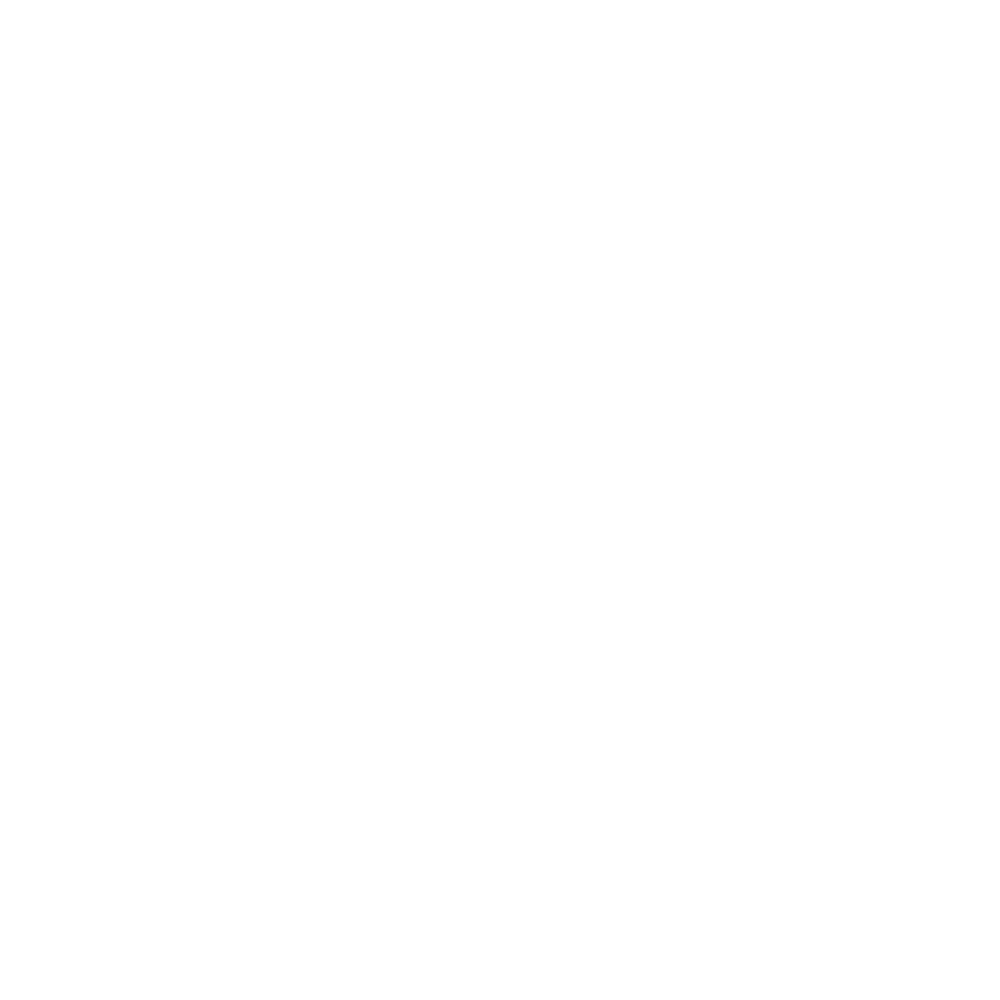

In [9]:
wnd_percentage_difference(200)

In [10]:
time_under_coverage_analysis_bs(200)

Loading BokehJS ...

Loading BokehJS ...

In [11]:
time_under_coverage_analysis_bs(115)

Loading BokehJS ...

Loading BokehJS ...

## Prediction Algorithms

## Visualization and Prediction Functions

In [12]:
%matplotlib nbagg

def movement_animation(data,predictions):
    true_pos = data[['x','y']].values
    pred_pos = predictions[['x','y']].values
    def update(i):
        # Update of the trace
        trace_3.set_data(true_pos[i-3][0], true_pos[i-3][1])
        trace_3.set_color('red')
        trace_3.set_alpha(0.01)
        trace_2.set_data(true_pos[i-2][0], true_pos[i-2][1])
        trace_2.set_color('red')
        trace_2.set_alpha(0.2)
        trace_1.set_data(true_pos[i-1][0], true_pos[i-1][1])
        trace_1.set_color('red')
        trace_1.set_alpha(0.4)
    
        # Update of true-pos
        true_scatter.set_data(true_pos[i][0], true_pos[i][1])
        true_scatter.set_color('red')
        true_scatter.set_alpha(1)
    
        # Update of the prediction
        pred_scatter.set_data(pred_pos[i][0], pred_pos[i][1])
        pred_scatter.set_color('blue')
        pred_scatter.set_alpha(0.5)
        return
    
    # Initialize the figure
    fig = plt.figure()
    # Add ax to get grid
    ax = fig.add_subplot()
    ax.grid(True, linestyle='-', color='0.75')
    plt.title("Movement and prediction animation ")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    
    # Create true-pos objects
    true_scatter, = plt.plot([], [], 'ro',  label= "Mesurement")
    pred_scatter, = plt.plot([], [], 'bo',  label = "Predicted position")
    plt.legend();
    # Create trace objects
    trace_1, = plt.plot([], [], 'bo')
    trace_2, = plt.plot([], [], 'bo')
    trace_3, = plt.plot([], [], 'bo')

    # We limit from the index 1 to avoid position (0,0)
    plt.xlim(np.min(true_pos[1:, 0]), np.max(true_pos[1:, 0]))
    plt.ylim(np.min(true_pos[1:, 1]), np.max(true_pos[1:, 1]))
    
    anim = FuncAnimation(fig, update, interval=500, frames=len(true_pos), blit=True, repeat=True)
    plt.show()
    return anim

#given 2 pandas dataset, print l2 error wrt position over time_line.
#return MSE

def l2_error(data,predictions,time_line, plot = False, verbose = False):
    data = data[['x','y']]
    predictions = predictions[['x','y']]
    length = len(data)
    l2 = np.zeros((0,2))
    for i in range(length):
        e =  (data.iloc[i].values - predictions.iloc[i].values )**2
        l2 = np.vstack([l2,e])
    
    l2 = np.array( l2[:,0] + l2[:,1] )
    if plot == True:
        plt.figure()
        plt.plot(time_line, l2)
        plt.title('L2-Error')
        plt.show()
        plt.ylabel('Squared Error [$m^2$]')
        plt.xlabel("Time [s]")
        
    if verbose:
        print(f'MSE: {np.mean(l2)}')
    return np.mean(l2)


## Linear Regression: Data Preparation

The Linear Regression is a method used to estimate the relation between some explanatory variables and some real valued outcome. In our case we tried to find the relation between the time-steps and the X,Y coordinates of vehicles.<br>
Analyzing the available data, it was noticed that a vehicle could enter, exit, and re-enter the tracking area several times, so in order not to have problems of time jumps, we decided to extract the longest continuous time track of the vehicle taken into consideration.

In [13]:
def pre_process(df_id=-1, verbose=False):

    # Extract BS coordinates and traces
    bs_coordinates, traces = vf.get_data()
    
    # Extract vehicle Id
    uniq_id = vf.compute_uniq_id(traces)
    
    if df_id < 0:
        # Choose a random vehicle
        ID = np.random.choice(uniq_id)
    else:
        ID = df_id
    
    if verbose:
        print(f'Veicolo Estratto: {int(ID)}')

    # Filter the traces by vehicle Id
    traces = traces[traces['id'] == ID]

    # Drop columns that we are not goint to use
    raw_data = traces.drop(['id'], axis=1)
    raw_data = raw_data.drop(['speed'], axis=1)
    raw_data = raw_data.drop(['C'], axis=1)
    raw_data = raw_data.drop(['C+1'], axis=1)
    raw_data = raw_data.drop(['C-1'], axis=1)
    raw_data = raw_data.drop(['C-2'], axis=1)
    raw_data = raw_data.drop(['C-3'], axis=1)

    # Extract the longest continuous time-trace
    time_line = raw_data['time'].values
    longest_seq = max(np.split(time_line, np.where(np.diff(time_line) != 1)[0]+1), key=len).tolist()    
    raw_data = raw_data[(raw_data['time'] >= longest_seq[0]) & (raw_data['time'] <= longest_seq[-1])]                          

    # Drop header and row-index -> numpy-array
    raw_values = raw_data.values
    
    return raw_values, ID

raw_values = pre_process()[0]
print(f'Numero di time-step: {raw_values.shape[0]}')
print(f'Numero di features: {raw_values.shape[1]}')



Numero di time-step: 118
Numero di features: 3


# Regression
The Regression is set to use the last n-positions in order to estimare the new one.<br>
For our tests we used a set of 5 older positions to train and predict the new one at each step.<br>
The standard Linear Regressione return very bad results for acceleration or when there are curves or turns with tight angles, so we "customized" the Regression algorithm in order that it will try to "fix" the last position that has predicted with a error larger that a predefined threshold. This has improved the overall prediction performance.



In [14]:
from sklearn import linear_model

def lin_reg_func(raw_values, wnd_size, adjust_param):

    # Initialize Regression model for both X-Y 
    regr_x = linear_model.LinearRegression()
    regr_y = linear_model.LinearRegression()

    # Initialize list for saving predictions
    pred_x = []
    pred_y = []
    error = []

    # Loop over the time-step to compute predictions
    for i in range(wnd_size +1, len(raw_values)):

        # Vector containing the training-window positions
        times = raw_values[i - wnd_size - 1 : i - 1, 0]

        # If we already predicted one position, and the error is large
        # use the last position fix to get better solution
        if len(pred_x) > 0 and error[-1] > 3:
            last_pos = np.array([raw_values[i-1, 1], raw_values[i-1, 2]])
            last_pred = np.array([pred_x[-1], pred_y[-1]])

            train_x = np.copy(raw_values[i - wnd_size - 1 : i - 1, 1])
            train_y = np.copy(raw_values[i - wnd_size - 1 : i - 1, 2])

            # Compute the error and fix the last position
            delta_error = adjust_param * np.array([last_pos[0] - last_pred[0], last_pos[1] - last_pred[1]])
            train_x[-1] = train_x[-1] + delta_error[0]
            train_y[-1] = train_y[-1] + delta_error[1]
        else:

            # Else use last recorded position
            train_x = np.copy(raw_values[i - wnd_size - 1 : i - 1, 1])
            train_y = np.copy(raw_values[i - wnd_size - 1 : i - 1, 2])

        # Time of the position so predict
        cur_t = raw_values[i, 0]

        # Reshape in columns
        times = times.reshape(-1, 1)
        train_x = train_x.reshape(-1, 1)
        train_y = train_y.reshape(-1, 1)
        cur_t = cur_t.reshape(-1, 1)

        # Train LR
        regr_x.fit(times, train_x)
        regr_y.fit(times, train_y)

        # Predict coordinates
        p_x = regr_x.predict(cur_t)
        p_y = regr_y.predict(cur_t)

        pred_x.append(p_x[0][0])
        pred_y.append(p_y[0][0])

        # Compute L2 ERROR
        e1 = np.linalg.norm(np.subtract([p_x[0][0], p_y[0][0]], [raw_values[i, 1], raw_values[i, 2]]))
        error.append(e1)
    
    # Convert predicted vector in pandas DaraFrame
    pred = np.array([pred_x, pred_y]).T
    pred = pd.DataFrame(pred,columns = ['x','y'])

    tot_times = raw_values[wnd_size + 1:, 0]

    data = pd.DataFrame(raw_values[wnd_size + 1:,:],columns = ['time','x','y'])
    MSE = l2_error(data,pred,tot_times, plot = False)
    return data, tot_times, pred, MSE

In order to get the best window-size and the best correction parameter-p we implemented a grid-search that will compute the best parameters for a predefined n-vehicles, after that we'll use the obtained 'best parameters' to make predictions.

In [31]:
import warnings
warnings.filterwarnings("ignore")

# Grid Search for the best windows-size and adjustment parameter
def grid_search(n, verbose=False):
    p_list = []
    wnd_list = []
    adj = [x * 0.1 for x in range(5, 15)]
    
    for v in range(n):
        print(f'Istance-{v+1}')
        raw_values = pre_process()[0]
        MSE = np.zeros((3, 10))
        min_wnd = -1
        min_p = -1
        min_MSE = -1
        
        for wnd in range(3, 6):
            for p_i in range(len(adj)):
                MSE[wnd-3][p_i-1] = lin_reg_func(raw_values, wnd_size=wnd, adjust_param=adj[p_i])[3]
                
                if np.isnan(MSE[wnd-3][p_i-1]) or np.isinf(MSE[wnd-3][p_i-1]):
                    #print('MSE nan or Inf')
                    continue
                    
                #print('MSE:', MSE[wnd-3][p_i-1])
                if min_MSE < 0 or MSE[wnd-3][p_i-1] < min_MSE:
                    min_wnd = wnd
                    min_p = p_i
                    min_MSE = MSE[wnd-3][p_i-1]
        
        if min_MSE == -1:
            continue
        else:
            if verbose:
                print(f'Best MSE: {min_MSE}   Best Window-Size: {min_wnd}   Best Adjustment Param: {adj[min_p]}\n')
            p_list.append(adj[min_p])
            wnd_list.append(min_wnd)

    final_p = sum(p_list)/len(p_list)
    final_wnd = sum(wnd_list)/len(wnd_list)
        
    return final_p, final_wnd


best_p, best_wnd = grid_search(10, verbose=True)
print(f'\nBest parameter-P: {best_p }   Best window-size: {round(best_wnd)}')


Istance-1
Best MSE: 28.852338042211393   Best Window-Size: 4   Best Adjustment Param: 0.7000000000000001

Istance-2
Best MSE: 83.33678775431864   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-3
Best MSE: 26.143323216183195   Best Window-Size: 4   Best Adjustment Param: 0.6000000000000001

Istance-4
Best MSE: 127.58355323242367   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-5
Best MSE: 70.1876368962889   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-6
Best MSE: 55.740600343383434   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-7
Best MSE: 67.07385179064526   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-8
Best MSE: 28.625090503999736   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-9
Best MSE: 26.324308504683987   Best Window-Size: 3   Best Adjustment Param: 0.5

Istance-10
Best MSE: 20.03337330358389   Best Window-Size: 4   Best Adjustment Param: 0.7000000000000001


Best parameter-P: 0.55   Best window-size: 3


In [32]:
raw_values, ID = pre_process(df_id=146412, verbose=True)
data, tot_times, pred, e = lin_reg_func(raw_values, wnd_size=round(best_wnd), adjust_param=best_p)

Veicolo Estratto: 146412


## Regression: L2-Error

<IPython.core.display.Javascript object>


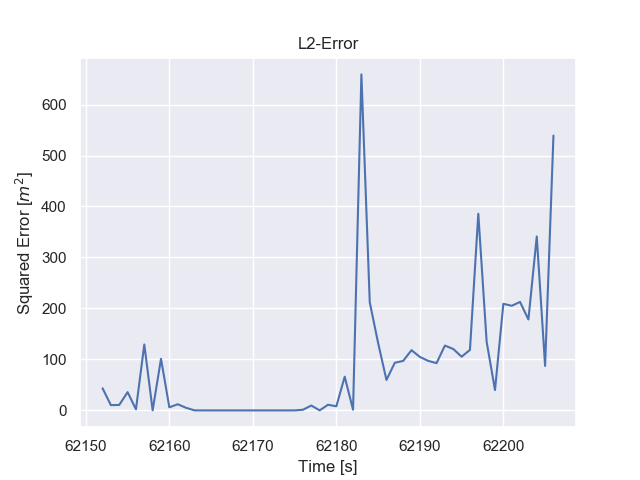

MSE: 89.54900542674814


<IPython.core.display.Javascript object>


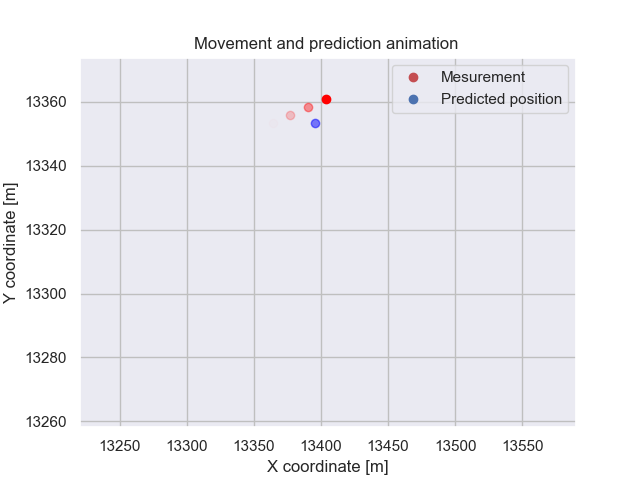

In [33]:
MSE = l2_error(data,pred,tot_times,plot = True, verbose = True)
movement_animation(data,pred)

<IPython.core.display.Javascript object>


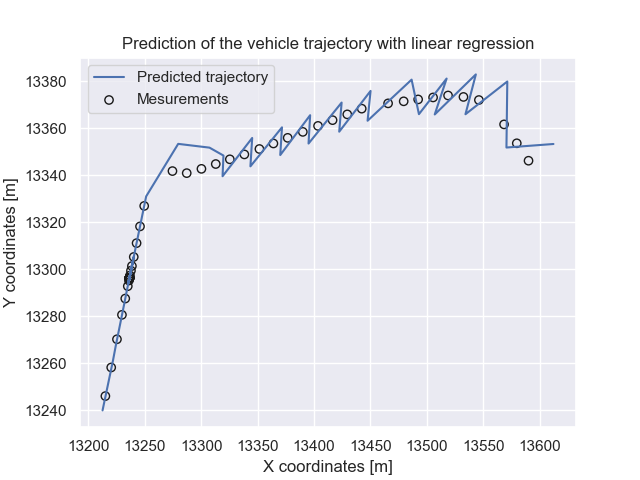

In [34]:
plt.figure()
plt.title("Prediction of the vehicle trajectory with linear regression")
plt.scatter(data['x'].values, data['y'].values,  marker='o',facecolors='none', edgecolors='k', label = "Mesurements")
plt.plot(pred['x'].values, pred['y'].values, label = "Predicted trajectory" )
plt.xlabel("X coordinates [m]")
plt.ylabel("Y coordinates [m]")
plt.legend();

As we can see from the animation the prediction is note very stable and suffer a lot from accelerations and curves, so we tried another method, the Kalman Filter.

## Kalman filter
For the prediction of the next position an alternative approach uses the Kalman Filter. The Kalman filter uses the previous state of the vehicle (position and speed) to estimate the next position.

The filter is composed of two iterable steps:
1. Prediction: by using the previous data an estimate of the position at $t_i$ using the equation:
$$ x_{i} =  F x_{i-1} $$
where F is the state transition matrix and P is the state covariance matrix.

Also P gets updated:
$$ P_i = F\cdot P_{i-1} \cdot F^{T} + Q  $$
where Q is the noise process covariance matrix.

2. Update: the model is updated with the mesurement at $t_i$.
The difference $y_i$ of the new mesurement $z_i$ and the prediction $x_i$:

$$y_i = z - H \cdot x_i$$
where H is the mesurement matrix, useful for mesurement conversion.

Given the Kalman gain $K$ as:
$$ K = P_i \cdot H^{T} ( H \cdot P_{i} \cdot H^{T} + R )^{-1}$$
where $R$ is the measure covariance matrix.

The update is described bu the equation:
$$ x^{'}_i = x_i + K \cdot y$$

And the matrix P is consequently updated:
$$P^{'}_i = (I - K\cdot H)\cdot P_i$$

A prediction for the following positions can be obtained by iterating the step 1.

With the step 2 the model is updated with the latest mesurement.


In [35]:
#Acquiring data for the kalman filter
bs_coordinates, traces = vf.get_data()
id_traces = traces[traces['id'] == ID]

#get longest time series for the vehicle
time_line = id_traces['time'].values
#select time_line 
longest_seq = max(np.split(time_line, np.where(np.diff(time_line) != 1)[0]+1), key=len)    
id_traces = id_traces[(id_traces['time'] >= longest_seq[0]) & (id_traces['time'] <= longest_seq[-1])]                          


### Kalman fillter class

In [36]:
# Select only the column needed for the kalman filter 

class Kalman_Filter:
    def __init__(self,id_traces):
        data = id_traces[[ 'x', 'y', 'speed']]
        x_diff = np.diff(data['x'].values)
        y_diff = np.diff(data['y'].values)
    
        data = data.iloc[1:]
        
        if(data.shape[0] == 0):
            return None
        
        data['speed_x'] = x_diff
        data['speed_y'] = y_diff

        dt = 1

        data = data[['x','speed_x','y','speed_y']]

        #Design of the Kalman Filter:
        x0 = np.array(data.iloc[0]) #initial conditions
        data = data.iloc[1:]             #remove initial condition from the dataset:
                                         #can't make prediction without any data

        R_std = 5/3   #Measurement std based on given data
        Q_std = 5/3  #Process Noise 
        wstd = 5/3
        self.P = np.diag(np.ones(4)*wstd) #variance matrix of measures
        self.F = np.array([[1,dt,0,0],   #state transition matrix
                           [0,1,0, 0],
                           [0,0,1,dt],
                           [0,0,0, 1]])

        q = np.array([[1/3*dt**3, 1/2*dt**1],
                     [ 1/2*dt**2,    dt]]) * (Q_std**2)
        #Reference for the choice of covariance for the process noise:    
        #Bar-Shalom. "Estimation with Applications To Tracking and Navigation"
        #.John Wiley & Sons, 2001. Page 273.


        self.Q = np.block([[q,  np.zeros((2, 2))],   #process noise matrix
                           [np.zeros((2, 2)), q ]])
    
        self.H = np.array([[1,0,0,0], #measurement matrix
                           [0,0,1,0]])
        self.R = np.eye(2)*(R_std**2) #measurement covariance matrix

        #setup data and variables useful to the filter
        self.x = x0 #initial state    
    
    #Kalman Function to predict the next position based on previous data
    def Kalman_predict(self, x = 0 , P = 0, number_of_predictions = 1):
        if x is 0:
            x = self.x
        if P is 0:
            P = self.P
        F,Q = self.F, self.Q
        xs_prior = []
        Ps_prior = []
        for i in range(number_of_predictions):
            x = F.dot(x)
            xs_prior.append(x)
            P = F.dot(P).dot(F.T) + Q 
            Ps_prior.append(P)
        return np.array(xs_prior), np.array(Ps_prior)

    #Kalman Function to update the model with latest information from the data 
    def Kalman_update(self,z):
        x,P,R,H = self.x, self.P, self.R, self.H
        y = z - H.dot(x)
        inverse = np.linalg.inv(H.dot(P).dot(H.T) + R)
        K = P.dot(H.T).dot(inverse)
        x_post = x + K.dot(y)
        P_post = (np.eye(P.shape[0]) - K.dot(H)).dot(P)
        return x_post, P_post

    def update_model(self,x,P):
        self.x = x
        self.P = P


#### Position prediction function

In [37]:
def vehicle_predictions(id_traces, number_of_predictions = 1):
    car_tracker = Kalman_Filter(id_traces)
    if car_tracker == None: # a problem occurred
        return None
    data = id_traces.iloc[1:]           #discard first measurement since the filter can't make prediction without any data
    data_z = data[['x','y']]            #select data to update the state of the model
    predictions_matrix = np.zeros((data_z.shape[0],4,number_of_predictions)) #array to store predictions

    #run the filter
    for i in range(data.shape[0]):
    
        #predictions for the next steps
        xs, Ps = car_tracker.Kalman_predict(number_of_predictions = number_of_predictions)
        x = xs[0]
        P = Ps[0]

        predictions_matrix[i,:,:] = xs.T
        car_tracker.update_model(x,P)
    
        #update step
        z = data_z.iloc[i].values
        x, P = car_tracker.Kalman_update(z)
        car_tracker.update_model(x,P)

    return predictions_matrix

predictions = vehicle_predictions(id_traces, number_of_predictions = 1)
predictions = pd.DataFrame(predictions[:,:,0], columns = ['x','speed_x','y','speed_y'])


<IPython.core.display.Javascript object>


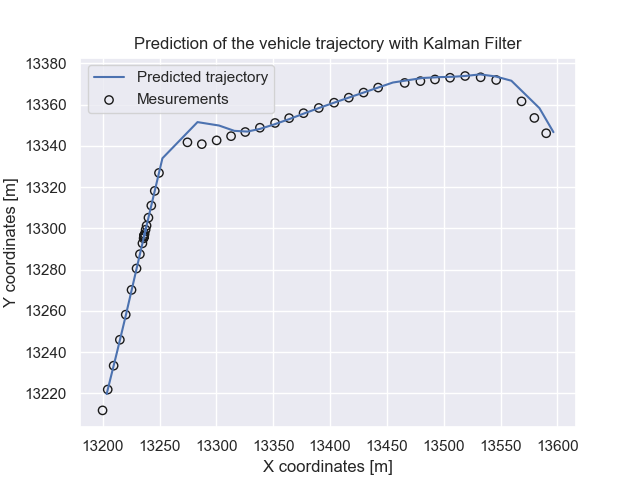

In [38]:
time_line = longest_seq[1:]
id_data = id_traces.iloc[1:]
plt.figure()


plt.title("Prediction of the vehicle trajectory with Kalman Filter")
plt.scatter(id_traces['x'].iloc[1:].values, id_traces.iloc[1:]['y'].values,  marker='o',facecolors='none', edgecolors='k', label = "Mesurements")
plt.plot(predictions.values[:, 0], predictions.values[:, 2], label = "Predicted trajectory" )
plt.xlabel("X coordinates [m]")
plt.ylabel("Y coordinates [m]")
plt.legend();

## Filtro di Kalman: errore L2

<IPython.core.display.Javascript object>


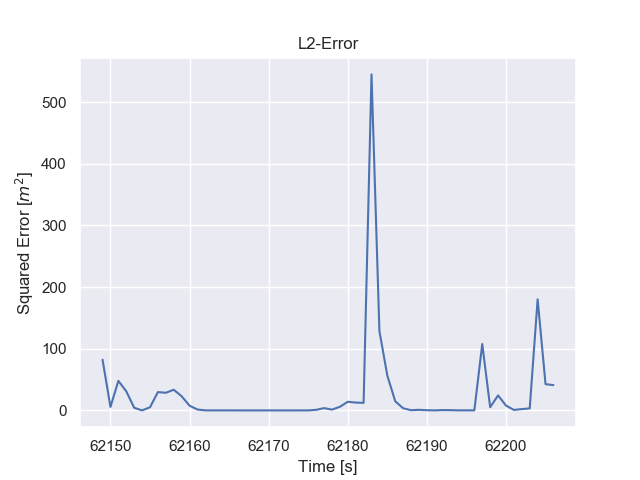

MSE: 26.14544261758112


In [39]:
time_line = longest_seq[1:]
MSE = l2_error(id_data,predictions,time_line,plot = True, verbose = True)

## Filter di Kalman:  Animazione Real Time

<IPython.core.display.Javascript object>


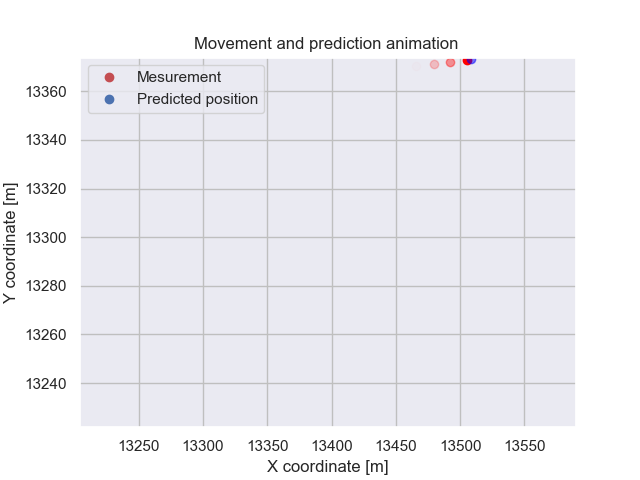

In [40]:

movement_animation(id_data,predictions)

#### Serving BS based on the coordinates

In [41]:
#predictions for all data.
def nearest_bs(bs_coordinates, car_coordinates):
    #bs_coordinates = bs_coordinates
    bs_coordinates = bs_coordinates[['x','y']].values
    
    bs = np.zeros((car_coordinates.shape[0]))
    for i in range(car_coordinates.shape[0]): #for every prediction
        dist =  np.sum((bs_coordinates - car_coordinates[i])**2, axis = 1 )
        bs[i] = int(np.argmin(dist))+1
        bs[-1] = -1
    
    return bs

### Prediction of the next serving Base stations for every car and every time
The following algorithm returns a matrix of the predicted base stations based on the predictions provided by the Kalman filter.

In [42]:
if not os.path.isfile('BS_predictions.h5'):
    print("Prediction of the next serving BS...")
    bs_coordinates, traces = vf.get_data()
    uniq_id = vf.compute_uniq_id(traces)
    i = 0
    number_of_predictions = 3
    traces['C+1_pred','C+2_pred','C+3_pred'] = np.nan

    for vehicle in uniq_id:
        vehicle_traces = traces[traces['id'] == vehicle]
        time_line = vehicle_traces['time'].values
        vehicle_time_lines = np.split(time_line, np.where(np.diff(time_line) != 1)[0]+1)
    
        index1= traces[traces['id'] == vehicle].index
    
        for time_line in vehicle_time_lines:
            #time_line_traces = vehicle_traces[(vehicle_traces['time'] >= time_line[0]) & (vehicle_traces['time'] <= time_line[-1])]                          
            time_line_traces = vehicle_traces[vehicle_traces['time'].isin(time_line)]                          
        
            prediction_matrix = vehicle_predictions(time_line_traces, number_of_predictions = 3)
            if(prediction_matrix.all() != None):# and i == 0):
            
                #index = traces[traces['id'] == vehicle][ traces['time'].isin(time_line)].index #return warning
                index = traces.query( 'time in @time_line  and id == @vehicle' ).index #index to place predictions
           
                bs = nearest_bs(bs_coordinates, (prediction_matrix[:,:,0])[:,[0,2]] )   
                traces.loc[index, 'C+1_pred'] = np.insert(bs,0,np.nan)
                
                bs = nearest_bs(bs_coordinates, (prediction_matrix[:,:,1])[:,[0,2]] )
                traces.loc[index, 'C+2_pred'] = np.insert(bs,0,np.nan)
            
                bs = nearest_bs(bs_coordinates, (prediction_matrix[:,:,2])[:,[0,2]] )
                traces.loc[index, 'C+3_pred'] = np.insert(bs,0,np.nan)
            

    pred = traces[['time','C+1','C+1_pred', 'C+2_pred', 'C+3_pred']]
    pred.to_hdf('BS_predictions.h5','table', mode='w',complevel = 9)
    
else:
    print("Serving BS predictions computed.")

Serving BS predictions computed.


#### Predictions of the next serving base station for every vehicle for every time step

The prediction of the next base station given only a measurement is NaN since it's impossible to make reasonable predictions.

In [43]:
BS_predictions = pd.read_hdf('BS_predictions.h5', 'table')
BS_predictions['id'] = traces['id']
BS_predictions['C'] = traces['C']
BS_predictions = BS_predictions[['id','time','C','C+1','C+1_pred','C+2_pred','C+3_pred']] 
BS_predictions

,id,time,C,C+1,C+1_pred,C+2_pred,C+3_pred
0,1.0,37081.0,174.0,174.0,NaN,NaN,NaN
1,1.0,37082.0,174.0,174.0,174.0,174.0,174.0
2,1.0,37083.0,174.0,174.0,174.0,174.0,174.0
3,1.0,37084.0,174.0,174.0,174.0,174.0,174.0
4,1.0,37085.0,174.0,174.0,174.0,174.0,174.0
...,...,...,...,...,...,...,...
6990451,718139.0,9701.0,149.0,149.0,149.0,149.0,149.0
6990452,718139.0,9702.0,149.0,149.0,149.0,149.0,149.0
6990453,718139.0,9703.0,149.0,149.0,149.0,149.0,149.0
6990454,718139.0,9704.0,149.0,149.0,149.0,149.0,149.0


### Correctness of the BS predictions

In [44]:
BS_predictions_filtered = BS_predictions[ BS_predictions['C+1_pred'] != -1 ].dropna()
rate = np.sum(BS_predictions_filtered['C+1'] == BS_predictions_filtered['C+1_pred'])/BS_predictions_filtered.shape[0]*100
print("Correctness of predicted BS at C+1 = %.4f%%" %rate)

ids = np.append(np.diff(BS_predictions['id'].values) == 0 , True)
BS_predictions_filtered2 = BS_predictions[ids]
rate2 = np.sum(BS_predictions_filtered['C+1'].values[1:] == BS_predictions_filtered['C+2_pred'].values[:-1])/(BS_predictions_filtered2.shape[0]-1)*100
print("Correctness of predicted BS at C+2 = %.4f%%" %rate2)


ids = np.append(np.diff(BS_predictions['id'].values) == 0 , True)
BS_predictions_filtered2 = BS_predictions[ids]
rate3 = np.sum(BS_predictions_filtered['C+1'].values[2:] == BS_predictions_filtered['C+3_pred'].values[:-2])/(BS_predictions_filtered2.shape[0]-1)*100
print("Correctness of predicted BS at C+2 = %.4f%%" %rate3)

Correctness of predicted BS at C+1 = 85.9249%
Correctness of predicted BS at C+2 = 79.6343%
Correctness of predicted BS at C+2 = 73.8752%


### Load of the BS in a given time interval

In [45]:
times = np.unique(BS_predictions_filtered[['time']].values)
delta_t = 60 #compute the n of vehicles per BS for the next 10 minutes

def BS_load(time_step, predictions, label):
    #extract times in time_step
    data = predictions[ predictions['time'].isin(time_step)]
    
    cs = np.unique(data[label].values)
    count = np.zeros((225))
    
    for j in range(len(cs)):
        count[int(cs[j])-1] = np.sum(data[label].values == cs[j])
    
    return count



 ### Dynamic visualization of BS load

<IPython.core.display.Javascript object>


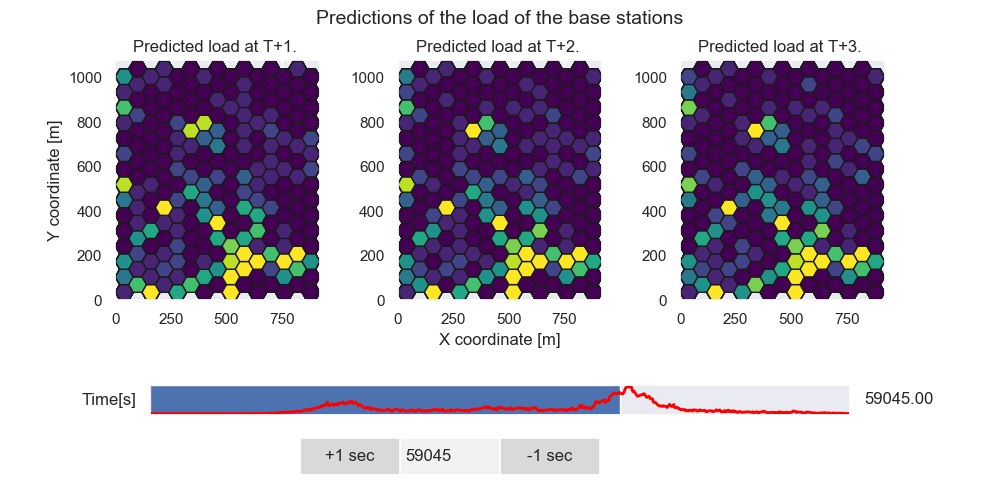

In [46]:
from matplotlib.widgets import Slider

def update_bs_cells2(predictions, curtime, figurename, bs_position, cmap_scale_color,label):

    collection = figurename.collections

    if len(collection) < 10:
        
        for xbs, ybs, ncarbs in zip(bs_position['x'], bs_position['y'],  BS_load(curtime, predictions, label) ):
            color = cmap_scale_color(ncarbs / auto_per_BS)
            hex_patch_apply = RegularPolygon((xbs, ybs), numVertices=6, radius=40,
                                        orientation=np.radians(30),
                                        facecolor=color, edgecolor='k')
            figurename.add_patch(hex_patch_apply)
    
    else:
        for ncarbs in BS_load(curtime, predictions, label):
            color = cmap_scale_color(ncarbs / auto_per_BS)
            collection[0].set_facecolor(color)
        
    fig.canvas.draw_idle()


bs_coordinates = pd.read_pickle('data_fast_loading/fast_bs_coordinates.plk')   
fig, axs_cell = plt.subplots(1, 3, figsize = (10,5))
plt.subplots_adjust(left=0.10, bottom=0.4)
fig.suptitle("Predictions of the load of the base stations", fontsize=14)

# -----------------------------------------------------------------------------SLIDER
axTime = plt.axes([0.15, 0.17, 0.70, 0.06])
sTime = Slider(axTime, 'Time[s]', ft_g[0], ft_g[-1], valstep=100)
p, = plt.plot(ft_g, nv_g, linewidth=2, color='red')

# -----------------------------------------------------------------------------TEXT BOX
axbox = plt.axes([0.4, 0.05, 0.1, 0.075])
text_box = TextBox(axbox, label='', initial=str(ft_g[0]))

# ------------------------------------------------------------------------------NEXT BUTTON

axnext = plt.axes([0.3, 0.05, 0.1, 0.075])
bnext = Button(axnext, '+1 sec')

# ------------------------------------------------------------------------------PREV BUTTON
axprev = plt.axes([0.5, 0.05, 0.1, 0.075])
bprev = Button(axprev, '-1 sec')
# -------------------------------------------------------------------------------------------Plot Base-Stations cells
colormap_scale = plt.get_cmap('viridis')  # settings colorscale
auto_per_BS = 10  
# -----------------
true_bs_coordinates, _ = vf.get_data()

def update(val):
    global BS_predictions_filtered
    text_box.set_val(int(val))
    update_bs_cells2(BS_predictions_filtered, [sTime.val], axs_cell[0], bs_coordinates, colormap_scale, 'C+1_pred')
    update_bs_cells2(BS_predictions_filtered, [sTime.val], axs_cell[1], bs_coordinates, colormap_scale, 'C+2_pred')
    update_bs_cells2(BS_predictions_filtered, [sTime.val], axs_cell[2], bs_coordinates, colormap_scale, 'C+3_pred')
   
for i in range(len(axs_cell)):
    axs_cell[i].set_aspect('equal')
    axs_cell[i].set_xlim(0,920)
    axs_cell[i].set_ylim(0, 1080)
    
    axs_cell[i].scatter(bs_coordinates['x'], bs_coordinates['y'], alpha=0)
    axs_cell[i].margins(x=0)
    update(sTime.val)
    axs_cell[i].set_title("Predicted load at T+%i. " %(i+1), fontsize=12)
    #locx = axs_cell[i].xticks()
    #locy = axs_cell[i].yticks()
    #axs_cell[i].set_xticks(locx, np.unique(true_bs_coordinates['x'].values))
    #axs_cell[i].set_yticks(locy, np.unique(true_bs_coordinates['y'].values))
    
axs_cell[1].set_xlabel("X coordinate [m]")
axs_cell[0].set_ylabel("Y coordinate [m]")
    
text_box.on_submit(submitTime)
sTime.on_changed(update)
bnext.on_clicked(next_time)
bprev.on_clicked(prev_time)

mng = plt.get_current_fig_manager()
#mng.window.state('zoomed')  # Open plot full screen on windows
plt.show()